In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# UNETR-2D for mitochondria segmentation in 2D
    
     Author: Aitor González
---
<figure>
<center>
<img src="https://www.epfl.ch/labs/cvlab/wp-target/uploads/2018/08/FIBSLICE0035_left_top.png" alt="EM image" width="256">
<img src="https://www.epfl.ch/labs/cvlab/wp-target/uploads/2018/08/masks_FIBSLICE0035_left_top.png" alt="Binary label image" width="256">
<figcaption>Input image (left) and corresponding semantic segmentation (right)</figcaption>
</figure>


## Getting started

In [ ]:
import os
# if repository is not downloaded (common if used colab link)
if not os.path.exists('./utils') and not os.path.exists('./models'):
    !git clone https://github.com/AAitorG/UNETR_2D.git UNETR_2D
    !python3 -m pip install -r UNETR_2D/requirements.txt

Cloning into 'UNETR_2D'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 29), reused 19 (delta 1), pack-reused 0
Receiving objects: 100% (68/68), 1.37 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (29/29), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
cd UNETR_2D/

/content/UNETR_2D


In [ ]:
cat models/UNETR_2D.py

#######################################
## Author: Aitor González (@AAitorG) ##
#######################################

from math import log2
from tensorflow.keras import Model, layers
from .modules import *

def UNETR_2D(
            input_shape,
            patch_size,
            num_patches,
            projection_dim,
            transformer_layers,
            num_heads,
            transformer_units,
            data_augmentation = None,
            num_filters = 16, 
            num_classes = 1,
            decoder_activation = 'relu',
            decoder_kernel_init = 'he_normal',
            ViT_hidd_mult = 3,
            batch_norm = True,
            dropout = 0.0
        ):

    """
    UNETR architecture adapted for 2D operations. It combines a ViT with U-Net, replaces the convolutional encoder with the ViT
    and adapt each skip connection signal to their layer's spatial dimensionality. 

    Note: Unlike the original UNETR, the sigmoid activation function is used in t

In [ ]:
from utils import *
from models import *

import numpy as np
import cv2
import gc
from matplotlib import pyplot as plt
from skimage import metrics

import tensorflow as tf
import tensorflow_addons as tfa # AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.backend import clear_session

set_gpu(gpu_id=0)
set_seed()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


We download and unzip the dataset (it might take a few minutes but later it is faster than having the data directly as images in Drive):

In [ ]:
if not os.path.exists('./Data'):
    # make a copy of the
    # Unzip FIBSEM (EPFL) dataset
    !wget 'https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download'
    !unzip -q download
    !rm download
    !mkdir Data
    !mv data Data/Lucchi

--2024-02-26 12:05:38--  https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225297821 (215M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 214.86M  3.14MB/s    in 4m 4s   

2024-02-26 12:09:43 (903 KB/s) - ‘download’ saved [225297821/225297821]



Now we should be able to read the list of **165 training images** and their corresponding 165 label images, that are organized as follows:

```
data/
    |-- train/
    |    |-- x/
    |    |      training-0001.tif
    |    |      ...
    |    |-- y/
    |    |      training_groundtruth-0001.tif
    |    |        ...
    |-- test/
    |    |-- x/
    |    |      testing-0001.tif
    |    |      ...
    |    |-- y/
    |    |      testing_groundtruth-0001.tif
    |    |      ...

```

## Preprocesamiento de Imágenes

In [ ]:
!pip install batchgenerators -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
train_x[0]

'/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/imagesTr/CS_0000_0000.png'

In [ ]:
import shutil
from batchgenerators.utilities.file_and_folder_operations import *
from skimage import io

train_x = subfiles('/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/imagesTr')
train_y = subfiles('/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/labelsTr')

test_x = subfiles('/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/imagesTs')
test_y = subfiles('/content/drive/MyDrive/TFG/V2/evaluationV2/labelsTs')


for file_path in train_x:
    parts = os.path.basename(file_path).split('_')
    new_filename = f"training-{parts[1]}.png"
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/x/{new_filename}')

for file_path in train_y:
    parts = os.path.basename(file_path).split('_')
    new_filename = f"training_groundtruth-{parts[1]}"
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/y/{new_filename}')

for file_path in test_x:
    parts = os.path.basename(file_path).split('_')
    new_filename = f"testing-{parts[1]}.png"
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/x/{new_filename}')

for file_path in test_y:
    parts = os.path.basename(file_path).split('_')
    new_filename = f"testing_groundtruth-{parts[1]}"
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/y/{new_filename}')

In [ ]:
import shutil
from batchgenerators.utilities.file_and_folder_operations import *
import random
import os

prev_train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/x')

num_files_to_move = int(len(prev_train_x) * 0.2)

files_to_move_train_x = random.sample(prev_train_x, num_files_to_move)

for file_path in files_to_move_train_x:
    file_name = os.path.basename(file_path)
    gt_name = f"training_groundtruth-{file_name.split('-')[1]}"
    gt_path = f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/y/{gt_name}'
    shutil.move(file_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/x/{file_name}')
    shutil.move(gt_path, f'/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/y/{gt_name}')


## Parameters

In [ ]:
data_path = '/content/drive/MyDrive/TFG/Uformer/data'
# Training dataset
train_datasets = 'CholecSeg8k'
# Test dataset
test_datasets = 'CholecSeg8k'

In [ ]:
## === Training parameters ===
# number of epochs
numEpochs = 150
# patience (if (patience <= 0): patience will not be used)
patience = 30
# learning rate
lr = 1e-4
# weight_decay  (for AdamW)
wd = 1e-5
# Scheduler: 'oneCycle', 'reduce', 'cosine',  None
schedule = 'oneCycle'
# Optimizer name: 'Adam', 'SGD', 'rmsprop', 'AdamW'
optimizer_name = 'AdamW'
# Loss function name: 'bce', 'bce_dice', 'mse'
loss_acronym = 'bce_dice'
# batch size
batch_size_value = 6

In [ ]:
## === Network parameters ===
# Network architecture: UNETR_2D, YNETR_2D,
model_name = 'UNETR_2D'
# initial filters (16 x num_channels)
num_filters = 32
# conv kernel initializer: 'glorot_uniform', 'he_normal'
kernel_init = 'he_normal'
# conv part activation function
activation = 'relu'
# patch size
patch_size = 16
# hidden dimension
hidden_dim = 64
# number of transformer encoders
transformer_layers = 4
# number of heads per MHA module
num_heads = 4
# transformer mlp dimentions
mlp_dim = [256, 64]
# number of output channels (number of classes)
out_channels = 1
# denoise type: cutout, gaussNoise, coarseSaltP, emulate_LR, gaussian_filter, defocusBlur, motionBlur, pixeldropout
posible_dataAug = []
# dropout value # [0.1, 0.1, 0.2, 0.2, 0.3] (list is also allowed)
dropout = 0.0
# multiple of ViT layers that will be used for each skip connection (Sm)
ViT_hidd_mult_skipC = 1
# Use Batch Normalization layers
batch_norm = True
# Use Data Augmentation
da = True
# tensorflow additional data augmentation layers (use tf layer, if multiple layers, then use sequential() and add them)
extra_tf_data_augmentation = None

In [ ]:
# === Extra parameters ===
# Load weights for FineTunning
use_saved_model = False
# Path to save weights (After training)
out_dir = '/content/drive/MyDrive/TFG/Uformer/checkpoints'
# Path to save plots
img_out_dir = '/content/drive/MyDrive/TFG/Uformer/progress'
# filenames for trained model weights (h5)
weights_filename = out_dir + '/weights-{}-src-{}-bce-nf-{}-bs-{}-{}-{}.h5'.format(
                                                    model_name, train_datasets, num_filters, batch_size_value,
                                                    optimizer_name, 'None' if schedule is None else schedule )
# Weights file path (weights that will be loaded if use_saved_model is TRUE)
model_path = ''

# image input size (this does not change the data size!)
input_shape = (256,256,3)
# number of random patches (with number lower than 0, sequential patches will be used)
n_patches = -1

# evaluation parameters
# patch size
patch_h, patch_w = (256,256)
# relevant patch size
relevant_h, relevant_w = (128,128)

## Prepare the data

In [ ]:
h_cuts = 0
v_cuts = 0

source_path = os.path.join(data_path, train_datasets, 'train')
ds_imgs, ds_lbls = get_xy_image_list(source_path)

assert len(ds_imgs) > 0, 'There in NO data, check path: {}.'.format(source_path)
assert len(ds_imgs) == len(ds_lbls), 'There is different ammount of images and labels. Images: {}  Labels: {}'.format(len(ds_imgs), len(ds_lbls))



Input images loaded: 6464 -- Label images loaded: 6464
	path: /content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train


ValueError: too many values to unpack (expected 2)

In [ ]:
h, w = ds_imgs[0].shape[0], ds_imgs[0].shape[1]
exp_h, exp_w, _ = input_shape

h_cuts = int(np.ceil(w/exp_w))
v_cuts = int(np.ceil(h/exp_h))

#print("h_cuts: {} \t v_cuts: {}".format(h_cuts, v_cuts))

if w%exp_w != 0 and h%exp_h != 0:
    w_parts = w/exp_w
    h_parts = h/exp_h
    new_w = int(np.ceil(w_parts))*exp_w
    new_h = int(np.ceil(h_parts))*exp_h
    # MIRROR PADDING
    ds_imgs = [mirror_border(x, new_h, new_w) for x in ds_imgs]
    ds_lbls = [mirror_border(x, new_h, new_w) for x in ds_lbls]
    # ZERO PADDING (for 256x256 patches by default)
    #ds_imgs = [add_padding(x) for x in ds_imgs]
    #ds_lbls = [add_padding(x) for x in ds_lbls]

if n_patches < 0:
    # sequential patches
    ds_imgs = create_patches( ds_imgs, h_cuts, v_cuts )
    ds_lbls = create_patches( ds_lbls, h_cuts, v_cuts )

    #ds_imgs, ds_lbls = filter_patches(ds_imgs, ds_lbls)
else:
    # random patches
    p_ds_imgs = []
    p_ds_lbls = []
    while len(p_ds_imgs)<n_patches:
        a,b = create_random_patches( ds_imgs, ds_lbls, 1, [256, 256] )
        #a, b = filter_patches(a, b)
        p_ds_imgs = p_ds_imgs + a
        p_ds_lbls = p_ds_lbls + b
    ds_imgs = p_ds_imgs[:n_patches]
    ds_lbls = p_ds_lbls[:n_patches]

ds_imgs = np.expand_dims(ds_imgs, axis=-1)
ds_lbls = np.expand_dims(ds_lbls, axis=-1)

input_images = np.array(ds_imgs)
gt_labels = np.array(ds_lbls)

train_data_size = input_images.shape[0] * 0.9
val_data_size = input_images.shape[0] * 0.1

print('\n Data shape:',input_images.shape)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)

In [ ]:
# get crappify function
crappify = get_crappify(posible_dataAug)
# Get generator
train_generator, val_generator = get_train_val_generators(  X_data = input_images,
                                                            Y_data = input_images if loss_acronym == 'mse' else gt_labels,
                                                            validation_split = 0.1,
                                                            rescale = 1./255,
                                                            horizontal_flip=True if da else False,
                                                            vertical_flip=True if da else False,
                                                            rotation_range = 180 if da else 0,
                                                            #width_shift_range=0.2,
                                                            #height_shift_range=0.2,
                                                            #shear_range=0.2,
                                                            batch_size=batch_size_value,
                                                            show_examples=False,
                                                            preprocessing_function = crappify if loss_acronym == 'mse' else None,
                                                            val_preprocessing_function = crappify if loss_acronym == 'mse' else None, )

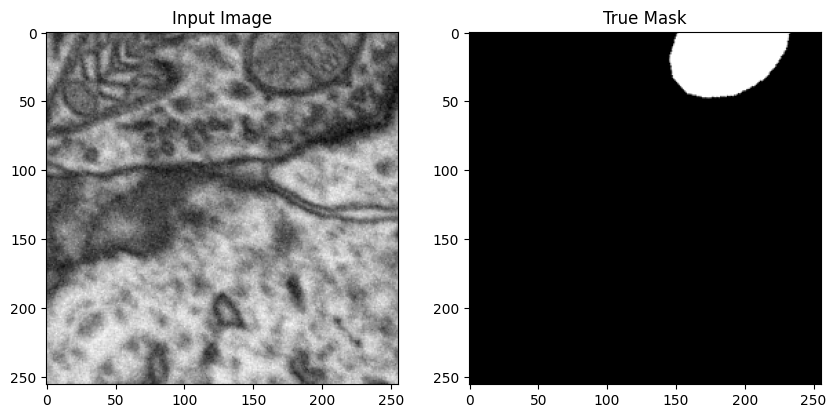

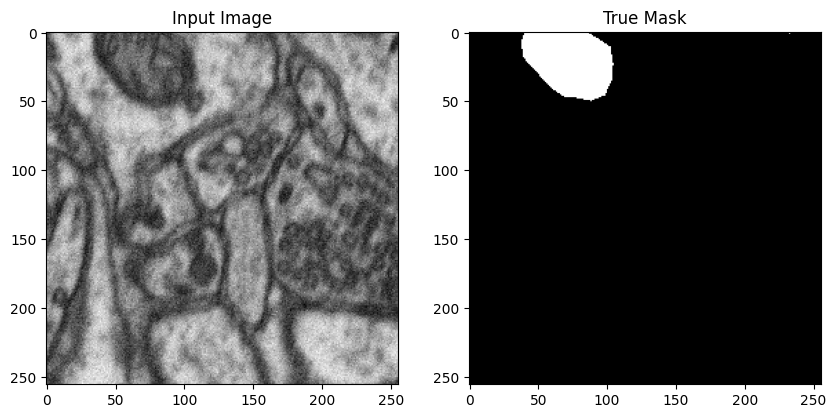

In [ ]:
for x, y in train_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break
for x, y in val_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break

## Compile


In [ ]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()
gc.collect()

### CALLBACKS ###
callbacks = []

if patience > 0:
    # callback for early stop
    earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
    callbacks.append(earlystopper)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    #steps = np.ceil(len(X_train) / batch_size_value) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
    callbacks.append(lr_schedule)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=patience, min_lr=(lr/10))
    callbacks.append(lr_schedule)
elif schedule == 'cosine':
    # this scheduler is not a callback
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    lr = tf.keras.optimizers.schedules.CosineDecay(lr, steps)


# create the network and compile it with its optimizer
if model_name == 'UNETR_2D':
    model = UNETR_2D(
            input_shape = input_shape,
            patch_size = patch_size,
            num_patches = (input_shape[0]**2)//(patch_size**2),
            projection_dim = hidden_dim,
            transformer_layers = transformer_layers,
            num_heads = num_heads,
            transformer_units = mlp_dim,
            data_augmentation = extra_tf_data_augmentation,
            num_filters = num_filters,
            num_classes = out_channels,
            decoder_activation = activation,
            decoder_kernel_init = kernel_init,
            ViT_hidd_mult=ViT_hidd_mult_skipC,
            batch_norm = batch_norm,
            dropout = dropout,
        )
elif model_name == 'YNETR_2D':
    model = YNETR_2D(
                input_shape = input_shape,
                patch_size = patch_size,
                num_patches = (input_shape[0]**2)//(patch_size**2),
                projection_dim = hidden_dim,
                transformer_layers = transformer_layers,
                num_heads = num_heads,
                transformer_units = mlp_dim,
                data_augmentation = extra_tf_data_augmentation,
                num_filters = num_filters,
                num_classes = out_channels,
                activation = activation,
                kernel_init = kernel_init,
                ViT_hidd_mult=ViT_hidd_mult_skipC,
                batch_norm = batch_norm,
                dropout = dropout,
            )


if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            lr=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )
elif optimizer_name == 'AdamW':
    optim = tfa.optimizers.AdamW( weight_decay = wd, learning_rate=lr )

model.summary()

if loss_acronym == 'bce':
    loss_funct = 'binary_crossentropy'
elif loss_acronym == 'bce_dice':
    loss_funct = bce_dice_loss
elif loss_acronym == 'mse': # dont change this acronym (is used to know when is training for denoising)
    loss_funct = 'mean_squared_error'

if loss_acronym == 'mse':
    eval_metric = [psnr, ssim]
else:
    eval_metric = jaccard_index

# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 patches (Patches)           (None, None, 256)            0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 256, 64)              32832     ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 256, 64)              128       ['patch_encoder[0][0]']   

### show model architecture
Have a quick look at the resulting model architecture:

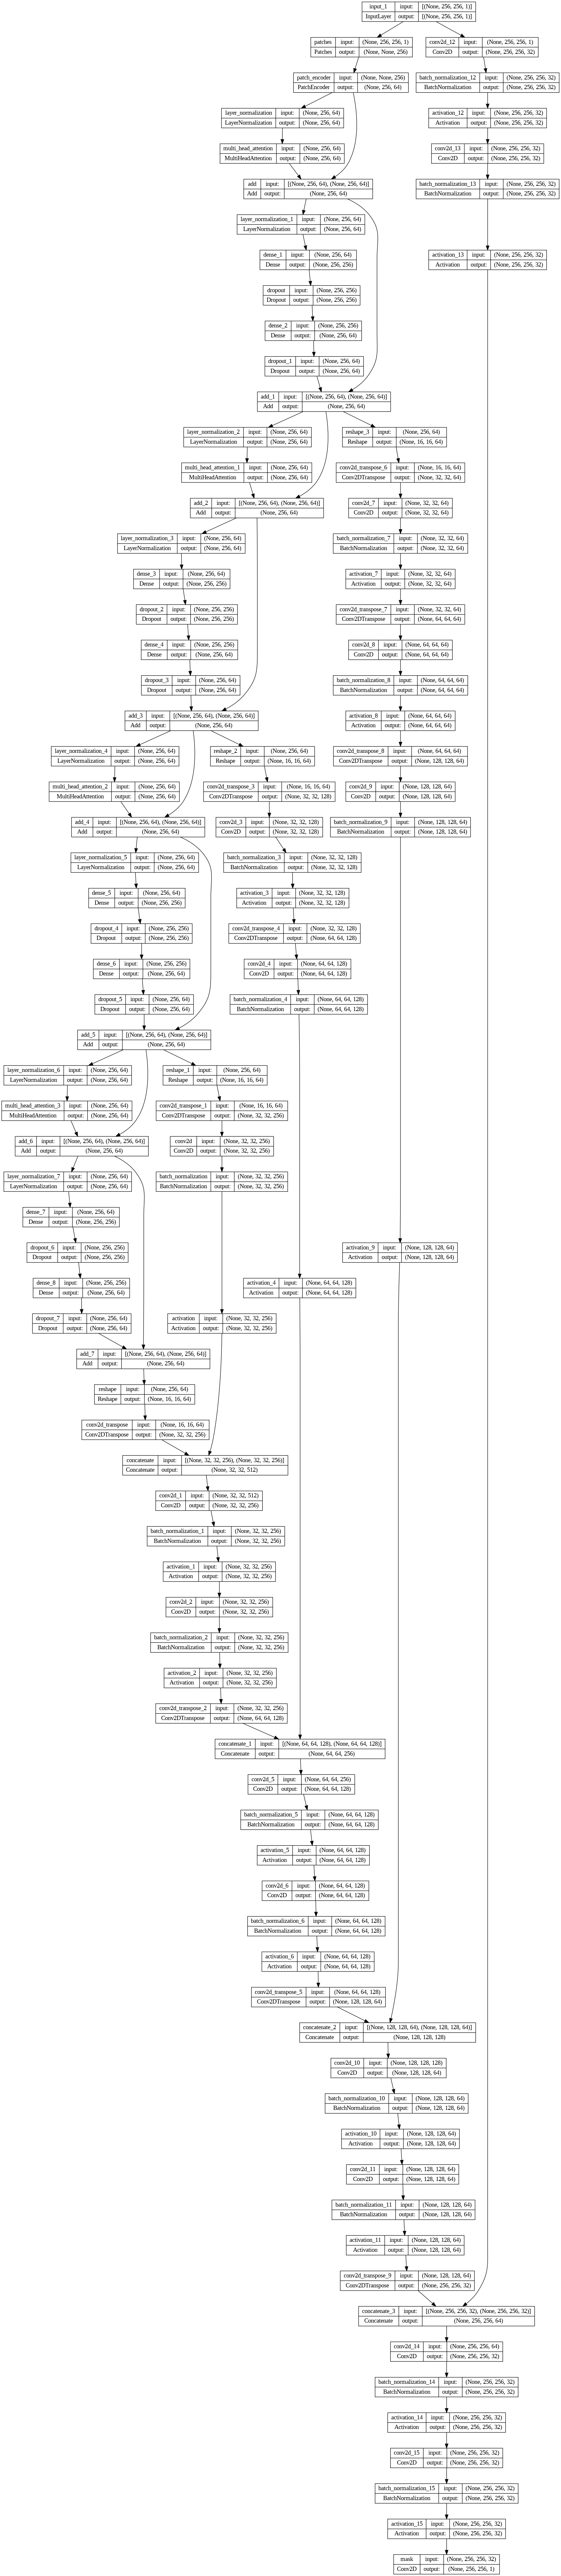

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Load saved model

In [ ]:
if use_saved_model:
    # Restore the weights
    model.load_weights(model_path) # change this

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)
    print("Weights loaded, and compiled")


## Train model

In [ ]:
history = model.fit(train_generator, validation_data=val_generator,
                    validation_steps=np.ceil(val_data_size/batch_size_value),
                    steps_per_epoch=np.ceil(train_data_size/batch_size_value),
                    epochs=numEpochs, callbacks=callbacks)

Epoch 1/150
297/297 [==============================] - 2228s 7s/step - loss: 0.5423 - jaccard_index: 0.0975 - val_loss: 0.4645 - val_jaccard_index: 0.0707
Epoch 2/150
297/297 [==============================] - 2195s 7s/step - loss: 0.4886 - jaccard_index: 0.1441 - val_loss: 0.4151 - val_jaccard_index: 0.0920
Epoch 3/150
248/297 [========================>.....] - ETA: 5:48 - loss: 0.4443 - jaccard_index: 0.2138

Plot loss - IoU

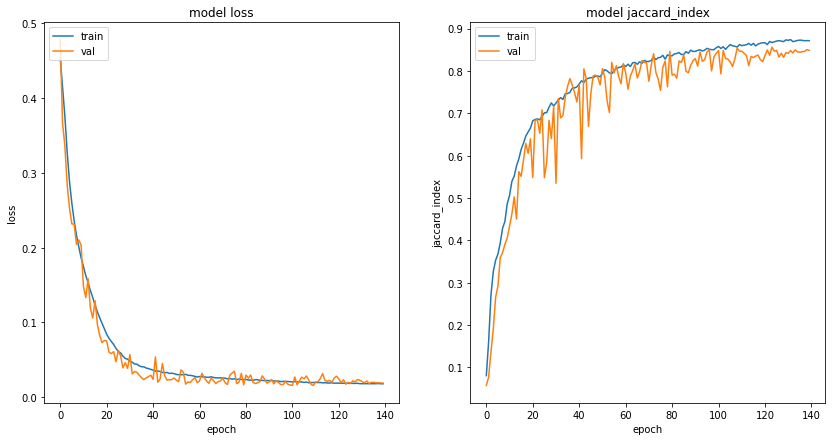

In [ ]:
track_metrics = ['loss', 'psnr', 'ssim'] if loss_acronym == 'mse' else ['loss', 'jaccard_index']
curve_name = 'loss-metric_curve_' + test_datasets + '_.png'
create_dir(img_out_dir)
plot_loss_and_metric(track_metrics, history, figsize=(14,7), save_fig_path=os.path.join(img_out_dir, curve_name))

### Save weights

In [ ]:
# Save weights for future reuse
create_dir(out_dir)
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

Saved model as ./model_weights/weights-UNETR_2D-src-Lucchi-bce-nf-32-bs-6-AdamW-oneCycle.h5


## Evaluation
\+ display examples

Method: Relevant patch with mirror padding

In [ ]:
### FULL IMAGE using relevant patch + sliding window + mirror padding
print('TEST: ', test_datasets)
source_test_data_path = os.path.join(data_path, test_datasets, 'test')
test_img, test_lbl = get_xy_image_list(source_test_data_path)

# Prepare the test data
X_test = [x/255 for x in test_img] # normalize between 0 and 1
X_test = np.expand_dims( np.asarray(X_test, dtype=np.float32), axis=-1 ) # add extra dimension
Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.float32), axis=-1 ) # add extra dimension

b, h, w, c = X_test.shape
print("\nTest shape =", X_test.shape )
del test_img, test_lbl

TEST:  Lucchi
Input images loaded: 165 -- Label images loaded: 165
	path: ./Data/Lucchi/test

Test shape = (165, 768, 1024, 1)


Inferring and measuring

In [ ]:
from tqdm.notebook import tqdm
# Now, we calculate the final test metrics
test_iou = []
test_psnr = []
test_ssim = []
test_mse = []
preds_test = []
input_test = []
i = 0

for img in tqdm(X_test):

    h, w, _ = img.shape

    if w%relevant_w != 0 and h%relevant_h != 0:
        w_parts = w/relevant_w
        h_parts = h/relevant_h
        new_w = int(np.ceil(w_parts))*relevant_w
        new_h = int(np.ceil(h_parts))*relevant_h
        pad_h = new_h - h # if pad==11 (odd): 6 top (near 0) - 5 bot
        pad_w = new_w - w # if pad==11 (odd): 6 L   (near 0) - 5 R
        same_shape_windows = False
    else:
        new_h = h + relevant_h
        new_w = w + relevant_w
        pad_h = relevant_h
        pad_w = relevant_w
        same_shape_windows = True

    image = np.expand_dims(mirror_border(img[:,:,0], new_h, new_w), axis=-1)

    rows = []
    x_rows = []
    # crete patches of (patch_h, patch_w) with (relevant_h, relevant_w) overlap between them
    for j in range(0, image.shape[0]-relevant_h, relevant_h):

        is_first_column = j == 0
        is_last_column = j == (image.shape[0]-relevant_h*2)

        columns = [] # patches of the first row
        for k in range(0, image.shape[1]-relevant_w, relevant_w):
            window = image[j:j + patch_h, k:k + patch_w, :]
            columns.append( window )
        columns = np.array(columns)

        # prepare input and gt (y)
        if loss_acronym == 'mse':
            y = img[:,:,0]
            columns = np.array(columns*255, dtype='uint8')
            columns = crappify(columns)
            columns = np.array(columns, dtype='float32')/255
        else:
            y = Y_test[i,:,:,0]

        _preds_test = model.predict_on_batch(columns)#, batch_size=columns.shape[0])

        if same_shape_windows:
            #all the patches contain the same padding so we can extract them directly
            relevant_windows = _preds_test[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                            relevant_w//2 : patch_w-(relevant_w//2), :]

            x_relevant = columns[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                    relevant_w//2 : patch_w-(relevant_w//2), :]
        else:
            # if pad==11 (odd): 5 top (near 0) - 6 bot
            # if pad==11 (odd): 6 L   (near 0) - 5 R

            # pad_h//2 padding in the top side  &&  round(pad_h/2)-1 padding in the bottom side
            from_row = pad_h//2 if is_first_column else relevant_h//2
            to_row = -round(pad_h/2) if is_last_column else patch_h-(relevant_h//2)

            # remove especial (smaller) padding in the top and bottom side, of the first or last row
            relevant_windows = _preds_test[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            x_relevant = columns[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]


            # convert into list otherwise numpy raise an error due to the shape differences
            relevant_windows = [im for im in relevant_windows]
            x_relevant = [im for im in x_relevant]


            # remove especial (smaller) padding in the sides
            # the relevant window contain round(pad_w/2) size padding in the left side
            from_column_L = round(pad_w/2)
            to_column_L = patch_w-(relevant_w//2)
            # the relevant window contain (pad_w//2) size padding in the right side
            from_column_R = relevant_w//2
            to_column_R = -(pad_w//2)

            # first column (left padding)
            relevant_windows[0] = _preds_test[0, from_row : to_row, from_column_L : to_column_L, :]
            x_relevant[0] = columns[0, from_row : to_row, from_column_L : to_column_L, :]
            # last column (right padding)
            relevant_windows[-1] = _preds_test[-1, from_row : to_row, from_column_R : to_column_R, :]
            x_relevant[-1] = columns[-1, from_row : to_row, from_column_R : to_column_R, :]

        rows.append(cv2.hconcat(relevant_windows)) # append relevant complete row
        x_rows.append(cv2.hconcat(x_relevant))

    x_recons = cv2.vconcat(x_rows)
    input_test.append(x_recons)
    recons_parts = cv2.vconcat(rows)
    preds_test.append(recons_parts) # append complete image

    if loss_acronym == 'mse':
        test_psnr.append(metrics.peak_signal_noise_ratio(recons_parts, y))
        test_ssim.append(metrics.structural_similarity(recons_parts, y))
        test_mse.append(metrics.mean_squared_error(recons_parts, y))
    else:
        test_iou.append( jaccard_index(y, recons_parts >= 0.5 ))

    i+=1


if loss_acronym == 'mse':
    mean_psnr = np.mean(test_psnr)
    mean_ssim = np.mean(test_ssim)
    mean_mse = np.mean(test_mse)
    print("\nTest PSNR:", mean_psnr)
    print("\nTest SSIM:", mean_ssim)
    print("\nTest MSE:", mean_mse)
else:
    mean_iou = np.mean(test_iou)
    print("\nTest IoU:", mean_iou)

  0%|          | 0/165 [00:00<?, ?it/s]


Test IoU: 0.846540433961524


Show inference examples

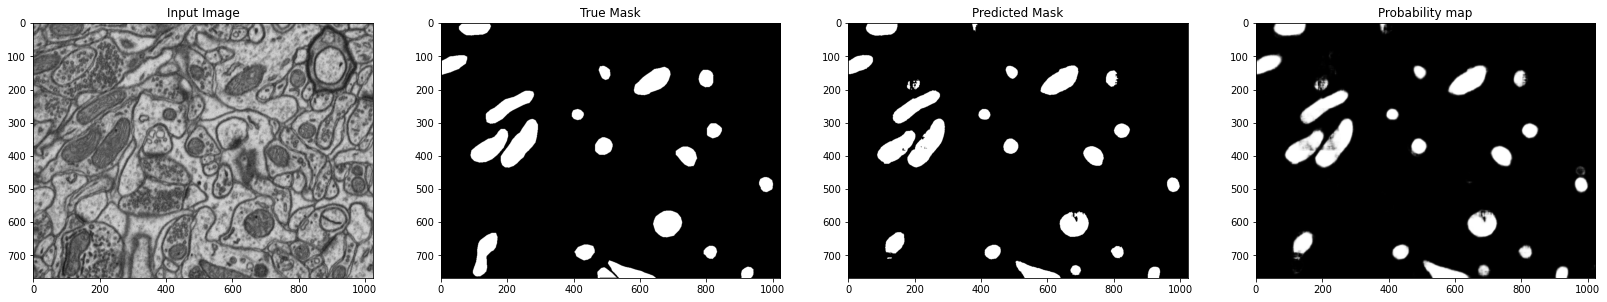

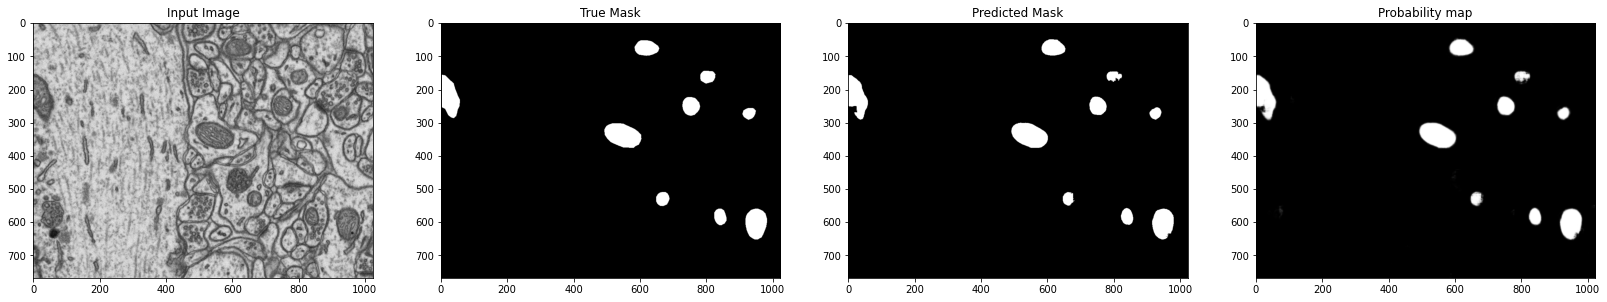

In [ ]:
first_pred_img_name = 'first pred plot.png'
last_pred_img_name = 'last pred plot.png'

if loss_acronym == 'mse':
    display_list1 = [input_test[0], X_test[0,:,:,0], preds_test[0]]
    display_list2 = [input_test[-1], X_test[-1,:,:,0], preds_test[-1]]
    display_titles = ['Input full image', 'Ground Truth', 'Predicted image']
else:
    display_list1 = [X_test[0,:,:,0], Y_test[0,:,:,0], preds_test[0]>=.5, preds_test[0]]
    display_list2 = [X_test[-1,:,:,0], Y_test[-1,:,:,0], preds_test[-1]>=.5, preds_test[-1]]
    display_titles = ['Input Image', 'True Mask', 'Predicted Mask', 'Probability map']

plt.figure(figsize=(7*4,7))
display(display_list1,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,first_pred_img_name),
        title = display_titles,
        )
plt.figure(figsize=(7*4,7))
display(display_list2,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,last_pred_img_name),
        title = display_titles,
        )